In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
from pathlib import Path
from plaid.evaluation import batch_rmsd_calculation, run_tmalign, RITAPerplexity, batch_rmspd_from_pdb_paths
from plaid.utils import extract_avg_b_factor_per_residue, read_sequences_from_fasta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sample_dir = Path("/data/lux70/plaid/artifacts/samples/scaling")

In [3]:
dfs = {}

for model_id in os.listdir(sample_dir):
    tmp = []
    for l in [48, 100, 148]:
        df = pd.read_csv(sample_dir / model_id / str(l) / "designability.csv")
        df['ID'] = [model_id] * len(df)
        # df['n_params'] = [hparam_tbl[hparam_tbl.ID == model_id]["cfg.trainable_params_millions"].values[0]] * len(df)
        # df['name'] = [hparam_tbl[hparam_tbl.ID == model_id]["Name"].values[0]] * len(df)
        # print(df.shape)
        tmp.append(df)
    df = pd.concat(tmp)
    if df.shape[0] > 0:
        dfs[model_id] = df

# for k, v in dfs.items():
#     print(k, v.shape)

In [4]:
hparam_tbl = pd.read_csv("plaid_hyperparameters.csv")
hparam_tbl = hparam_tbl[hparam_tbl.ID.isin(set(dfs.keys()))]
hparam_tbl = hparam_tbl.sort_values(by="Runtime",ascending=False)

print(hparam_tbl.shape)
hparam_tbl

(11, 199)


,Name,ID,Runtime,cfg.trainable_params_millions,cfg.denoiser.attention_mode,cfg.denoiser.max_seq_len,cfg.denoiser.use_skip_connect,cfg.trainer.gradient_clip_val,cfg.trainer.precision,cfg.denoiser.hidden_size,...,sample.model_ckpt_dir,sample.model_id,sample.num_samples,sample.organism_idx,sample.output_root_dir,sample.return_all_timesteps,sample.sample_scheduler,sample.sampling_timesteps,wandb_project_name,sample_latent_time
0,UDiT_B_AblationE2_skip,lqp25b7g,2049263,167.690752,xformers_memory_efficient,512,True,1.0,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UDiT_B_AblationE2,ksme77o6,1898234,134.021632,xformers_memory_efficient,512,False,1.0,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,L,4hdab8dn,1744688,898.006912,NaN,256,NaN,0.5,bf16-mixed,1280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,UDiT_XXL,5j007z42,1508629,1762.218240,xformers_memory_efficient,256,False,0.5,32,2048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,Base,6ryvfi2v,563466,134.021504,NaN,512,NaN,0.5,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,AblationF__NoCondDrop,zlkurtdd,521517,134.021632,xformers_memory_efficient,256,False,1.0,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,AblationD__A+predv+minsnr+sigmoid,93qqcdh9,521429,134.015264,xformers_memory_efficient,256,False,1.0,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,AblationC__A+minsnr,oa5kjy9x,521414,134.015264,xformers_memory_efficient,256,False,1.0,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,AblationA,ye1j29dh,521346,134.015264,xformers_memory_efficient,256,False,1.0,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,AblationF__NoCondDrop,87up71bi,503728,134.021632,xformers_memory_efficient,256,False,1.0,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(model_id)
hparam_tbl[hparam_tbl.ID == model_id]["cfg.trainable_params_millions"].values[0]

93qqcdh9


134.015264

In [6]:
dfs.keys()

dict_keys(['ksme77o6', 'zlkurtdd', '4hdab8dn', 'lqp25b7g', 'oa5kjy9x', 'ye1j29dh', '5j007z42', 'f0luhi8y', '6ryvfi2v', '87up71bi', '93qqcdh9'])

In [7]:
big_df = pd.concat(list(dfs.values()))
print(big_df.shape)
big_df.head()

(2368, 27)


,Unnamed: 0,pdb_paths,sequences,inverse_generated_pdb_paths,inv_gen_seqs,phantom_generated_pdb_paths,phantom_gen_seqs,plddt,ccrmsd,ccTM,...,isoelectric_point,gravy,charge_at_pH,ccsr,scsr,alpha_fraction,beta_fraction,dssp_annotation,ID,cctm
0,0,/data/lux70/plaid/artifacts/samples/scaling/ks...,LTSISVSDRALILESELDQWLHEAGAHPKEVLYRQKGIVDIPSAGD...,/data/lux70/plaid/artifacts/samples/scaling/ks...,MKKITVETDKVIPKEKLEELIKEICSYPDKKLVKLEGTVLLPENKT...,/data/lux70/plaid/artifacts/samples/scaling/ks...,METITVETNKKIKKKDFEKLIEELNKDPNVKLVKLEGLVYFPETKS...,53.556247,2.225364,0.89912,...,4.850776,-0.095833,-6.875829,0.218750,0.177083,0.177083,0.406250,CEEEEEEESSCCCHHHHHHHHHHHTTCTTCEEEEEEEEEECGGGSS...,ksme77o6,NaN
1,1,/data/lux70/plaid/artifacts/samples/scaling/ks...,ESVSIYMQTELKNAEAERIMDQIKSEPGVKAARYASKEEGLRRFQA...,/data/lux70/plaid/artifacts/samples/scaling/ks...,MVIKIPLPKELTPEEAEELKKKLLELEGVKSVKFLTKEEEIELFKK...,/data/lux70/plaid/artifacts/samples/scaling/ks...,MVLRIELPRDLTPEEAEELKKKLLSIEGVKSVRFKTREELIEEFRE...,58.013798,1.146107,0.93783,...,5.450825,-0.566667,-1.146713,0.218750,0.239583,0.166667,0.187500,CEEEEECSSCCCHHHHHHHHHHHHHSTTEEEEEEECHHHHHHHHHH...,ksme77o6,NaN
2,2,/data/lux70/plaid/artifacts/samples/scaling/ks...,SYLVVSMLLFAIGAFGLMVRRNVIAIMSAIELLLAAINIDLVAFSR...,/data/lux70/plaid/artifacts/samples/scaling/ks...,MWLKISLLLLLIGVIGFITEKNPIAILISIFIIILAIMIFIIYFSK...,/data/lux70/plaid/artifacts/samples/scaling/ks...,SLLKIAILLLLIGILLLIISKNPIAKLISIILIILSICILLIYVSK...,78.145488,2.058794,0.93326,...,6.498254,1.181250,-0.443943,0.250000,0.239583,0.083333,0.000000,CHHHHHHHHHHHHHHHHHHCCBHHHHHHHHHHHHHHHHHHHHHHII...,ksme77o6,NaN
3,3,/data/lux70/plaid/artifacts/samples/scaling/ks...,TNVWTHFAILTLLIPVIYHLVDKQNLLFLFFINGIAFALTNHILLR...,/data/lux70/plaid/artifacts/samples/scaling/ks...,MEKEKLKEILEKLKPELKEWYKEDPEIEKLWKEFLEFIEEAEKLLE...,/data/lux70/plaid/artifacts/samples/scaling/ks...,LSEEELKKFLEELKPKYEKLKKKPPLIEKLFNEIIKFVKEVLEKLK...,55.283909,2.261339,0.86520,...,8.246941,1.064583,0.666234,0.135417,0.166667,0.083333,0.000000,CHHHHHHHHHHHHHHHHHHHCCSCTHHHHHHHHHHHHHHHHHHHHH...,ksme77o6,NaN
4,4,/data/lux70/plaid/artifacts/samples/scaling/ks...,AFETDSTTLDPTSARQLSNLISALQHAPNLMAELTGHVDAAGSAAA...,/data/lux70/plaid/artifacts/samples/scaling/ks...,MLPPEAEELPPELRAALDALVAHLRANPDARAVLRGLAPPEGSPEE...,/data/lux70/plaid/artifacts/samples/scaling/ks...,MFEPDSDTLTPELQAALDALIAHLRAHPDARATLRGYSKADLSPEE...,63.189855,1.025460,0.94595,...,6.037631,-0.186458,-1.838074,0.281250,0.343750,0.270833,0.104167,CCCTTCSCCCHHHHHHHHHHHHHHHHCTTCCEEEEECCCSCSCHHH...,ksme77o6,NaN


In [8]:
big_df = big_df.merge(hparam_tbl, on="ID", how="left")

In [9]:
print(big_df.shape)
big_df.head()

(2368, 225)


,Unnamed: 0,pdb_paths,sequences,inverse_generated_pdb_paths,inv_gen_seqs,phantom_generated_pdb_paths,phantom_gen_seqs,plddt,ccrmsd,ccTM,...,sample.model_ckpt_dir,sample.model_id,sample.num_samples,sample.organism_idx,sample.output_root_dir,sample.return_all_timesteps,sample.sample_scheduler,sample.sampling_timesteps,wandb_project_name,sample_latent_time
0,0,/data/lux70/plaid/artifacts/samples/scaling/ks...,LTSISVSDRALILESELDQWLHEAGAHPKEVLYRQKGIVDIPSAGD...,/data/lux70/plaid/artifacts/samples/scaling/ks...,MKKITVETDKVIPKEKLEELIKEICSYPDKKLVKLEGTVLLPENKT...,/data/lux70/plaid/artifacts/samples/scaling/ks...,METITVETNKKIKKKDFEKLIEELNKDPNVKLVKLEGLVYFPETKS...,53.556247,2.225364,0.89912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,/data/lux70/plaid/artifacts/samples/scaling/ks...,ESVSIYMQTELKNAEAERIMDQIKSEPGVKAARYASKEEGLRRFQA...,/data/lux70/plaid/artifacts/samples/scaling/ks...,MVIKIPLPKELTPEEAEELKKKLLELEGVKSVKFLTKEEEIELFKK...,/data/lux70/plaid/artifacts/samples/scaling/ks...,MVLRIELPRDLTPEEAEELKKKLLSIEGVKSVRFKTREELIEEFRE...,58.013798,1.146107,0.93783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,/data/lux70/plaid/artifacts/samples/scaling/ks...,SYLVVSMLLFAIGAFGLMVRRNVIAIMSAIELLLAAINIDLVAFSR...,/data/lux70/plaid/artifacts/samples/scaling/ks...,MWLKISLLLLLIGVIGFITEKNPIAILISIFIIILAIMIFIIYFSK...,/data/lux70/plaid/artifacts/samples/scaling/ks...,SLLKIAILLLLIGILLLIISKNPIAKLISIILIILSICILLIYVSK...,78.145488,2.058794,0.93326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,/data/lux70/plaid/artifacts/samples/scaling/ks...,TNVWTHFAILTLLIPVIYHLVDKQNLLFLFFINGIAFALTNHILLR...,/data/lux70/plaid/artifacts/samples/scaling/ks...,MEKEKLKEILEKLKPELKEWYKEDPEIEKLWKEFLEFIEEAEKLLE...,/data/lux70/plaid/artifacts/samples/scaling/ks...,LSEEELKKFLEELKPKYEKLKKKPPLIEKLFNEIIKFVKEVLEKLK...,55.283909,2.261339,0.86520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,/data/lux70/plaid/artifacts/samples/scaling/ks...,AFETDSTTLDPTSARQLSNLISALQHAPNLMAELTGHVDAAGSAAA...,/data/lux70/plaid/artifacts/samples/scaling/ks...,MLPPEAEELPPELRAALDALVAHLRANPDARAVLRGLAPPEGSPEE...,/data/lux70/plaid/artifacts/samples/scaling/ks...,MFEPDSDTLTPELQAALDALIAHLRAHPDARATLRGYSKADLSPEE...,63.189855,1.025460,0.94595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

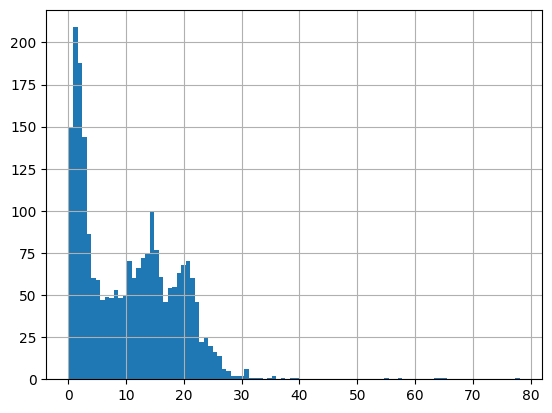

In [10]:
big_df.ccrmsd.hist(bins=100)

In [11]:
scaling = ["6ryvfi2v", "4hdab8dn", "5j007z42"]

In [12]:
list(dfs.values())[0].columns

Index(['Unnamed: 0', 'pdb_paths', 'sequences', 'inverse_generated_pdb_paths',
       'inv_gen_seqs', 'phantom_generated_pdb_paths', 'phantom_gen_seqs',
       'plddt', 'ccrmsd', 'ccTM', 'designable', 'scrmsd', 'sctm', 'perplexity',
       'molecular_weight', 'aromaticity', 'instability_index',
       'isoelectric_point', 'gravy', 'charge_at_pH', 'ccsr', 'scsr',
       'alpha_fraction', 'beta_fraction', 'dssp_annotation', 'ID'],
      dtype='object')

In [13]:
def get_stat(df_dict, stat, model_id):
    tmp = df_dict[model_id]
    return tmp[stat].mean(), tmp[stat].std()

mean_plddts = [get_stat(dfs, "plddt", model_id)[0] for model_id in scaling]
mean_ccrmsds = [get_stat(dfs, "ccrmsd", model_id)[0] for model_id in scaling]
mean_perps = [get_stat(dfs, "perplexity", model_id)[0] for model_id in scaling]
std_plddts = [get_stat(dfs, "plddt", model_id)[1] for model_id in scaling]
std_ccrmsds = [get_stat(dfs, "ccrmsd", model_id)[1] for model_id in scaling]
std_perps = [get_stat(dfs, "perplexity", model_id)[1] for model_id in scaling]

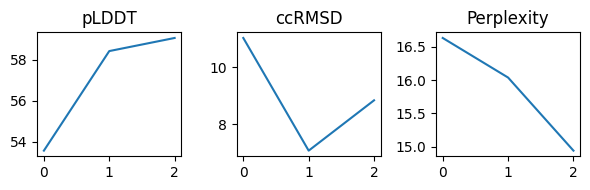

In [14]:
fig, axs = plt.subplots(1,3, figsize=(6,2))
axs[0].plot(mean_plddts,)
axs[0].set_title("pLDDT")
axs[1].plot(mean_ccrmsds)
axs[1].set_title("ccRMSD")
axs[2].plot(mean_perps)
axs[2].set_title("Perplexity")


plt.tight_layout()
plt.show()

In [15]:
scaling

['6ryvfi2v', '4hdab8dn', '5j007z42']

# Ablation Table

In [21]:
tmp = big_df.filter(["Name", "cfg.trainable_params_millions", "ccrmsd", "plddt", "ccTM", "scrmsd", "sctm", "ccsr", "scsr", "alpha_fraciton", "beta_fraction", "perplexity"], axis=1)
tmp.groupby("Name").mean().round(2)
#big_df.groupby("Name")['ccrmsd'].mean()

,cfg.trainable_params_millions,ccrmsd,plddt,ccTM,scrmsd,sctm,ccsr,scsr,beta_fraction,perplexity
Name,,,,,,,,,,
AblationA,134.02,12.22,53.69,0.54,13.39,0.55,0.22,0.22,0.13,16.97
AblationB__A+predv,134.02,12.64,50.85,0.52,13.86,0.53,0.21,0.22,0.13,17.37
AblationC__A+minsnr,134.02,11.05,54.85,0.59,11.50,0.59,0.23,0.23,0.13,16.76
AblationD__A+predv+minsnr+sigmoid,134.02,11.53,53.06,0.56,11.89,0.58,0.22,0.23,0.14,16.88
AblationF__NoCondDrop,134.02,11.67,51.38,0.56,12.42,0.57,0.22,0.22,0.14,17.24
Base,134.02,11.04,53.57,NaN,11.26,0.62,NaN,NaN,NaN,16.63
L,898.01,7.06,58.43,0.71,7.80,0.69,0.25,0.26,0.18,16.04
UDiT_B_AblationE2,134.02,8.09,58.76,0.70,10.15,0.65,0.26,0.26,0.15,15.38
UDiT_B_AblationE2_skip,167.69,10.76,56.06,0.59,12.17,0.58,0.24,0.25,0.12,15.96
